In [1]:
from typing import Optional, Tuple

import cv2
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from numpy.random._generator import Generator
from torchvision.transforms import ToPILImage, ToTensor, RandomAffine
from torchvision.utils import make_grid

In [2]:
from biomedical_image_segmentation.plot_utils import insert_grid

In [51]:

def _compute_ref_points(
    height: int, width: int, ref_ratio: float
) -> np.ndarray:
    """Compute 3 reference points within image space.

    Args:
        height: height of the image.

        width: width of the image.

        ref_ratio: A float value to pick reference points within image space.
            ref_ratio is expected to be greater than 1.

    Returns:
        3 reference points within image space.
    """
    assert ref_ratio != 0
    center_coords = np.float32([height, width]) // 2
    ref_pt = min([height, width]) // ref_ratio

    # fix 3 points in original image space
    orig_ref_pts = np.float32(
        [
            center_coords - ref_pt,
            center_coords + np.array([1.0, -1.0]) * ref_pt,
            center_coords + ref_pt,
        ]
    )
    return orig_ref_pts

In [52]:
def _compute_ref_points_in_warp_space(
    orig_ref_pts: np.ndarray, alpha: float, rng: Generator
) -> np.ndarray:
    """Compute 3 reference points in warp/affine space.

    Args:
        orig_ref_points: 3 reference points in original image space.

        alpha: A float value to compute affine transformation matrix.

        rng: The initialized generator object.

    Returns:
        3 reference points in warp/affine space."""
    
    u = rng.uniform(
        low=-alpha, high=alpha, size=orig_ref_pts.shape
    ).astype(np.float32)
    print(u)
    
    return orig_ref_pts + u

In [53]:
def getAffineTransform(
    img: np.ndarray,
    ref_ratio: float,
    alpha: float,
    rng: Generator,
    height: int = None,
    width: int = None,
    num_channels: int = None,
) -> np.ndarray:
    """Compute Affine Transformed image.

    Args:
        img: A NumPy array of type uint8.
            H * W * C
            H: height of the image.

            W: width of the image.

            C: number of channels in image.

        ref_ratio: A float value to pick reference points within image space.
            ref_ratio is expected to be greater than 1.

        alpha: A float value to compute affine transformation matrix.

        rng: The initialized generator object.

        height: height of the image.

        width: width of the image.

        num_channels: number of channels in the image.

    Returns:
        A NumPy array of type uint8.
            H * W * C
            H: height of the image.

            W: width of the image.

            C: number of channels in image.
    """
    # perform affine transformation
    # https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/warp_affine/warp_affine.html
    if None in [height, width, num_channels]:
        height, width, num_channels = img.shape

    orig_ref_pts = _compute_ref_points(height, width, ref_ratio)
    print(orig_ref_pts)
    warp_ref_pts = _compute_ref_points_in_warp_space(
        orig_ref_pts, alpha, rng=rng
    )

    # get affine transformation matrix to transform (x,y) points
    # from original image space to affine transformed image space
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
    M = cv2.getAffineTransform(orig_ref_pts, warp_ref_pts)
    img = cv2.warpAffine(
        src=img, M=M, dsize=(width, height), borderMode=cv2.BORDER_REFLECT_101
    )

    # this step is required as cv2.getAffineTransform will remove axis for channel
    #   if number of channels = 1
    if num_channels == 1 and img.ndim < 3:
        img = np.expand_dims(img, axis=-1)
    return img

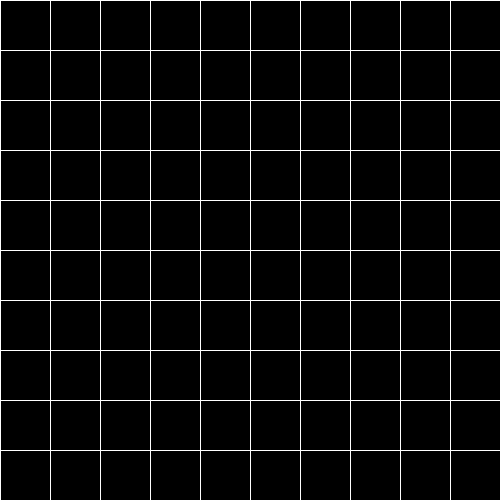

In [54]:
img = ToPILImage()(
    insert_grid(
        np.zeros((500, 500, 3)), 
        grid_size=(50, 50),
        color=(255,255,255), 
        thickness=1).astype(np.uint8))
img

In [55]:
from torchvision.transforms import InterpolationMode

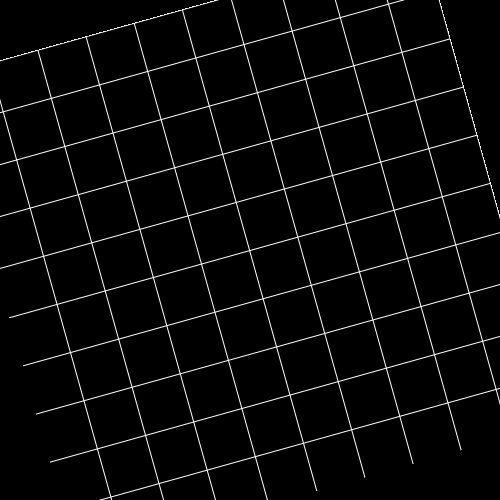

In [56]:
RandomAffine(degrees=(0, 90), interpolation=InterpolationMode.BILINEAR )(img)

In [57]:
rng.uniform(-10, 10, (2,2,3))

array([[[ 3.7807296 ,  6.83495449, -1.48982005],
        [ 9.13852007,  6.50665813, -3.23569375]],

       [[ 1.51521096,  5.06603729,  6.54207874],
        [ 8.66876942, -7.1001061 ,  4.91160422]]])

[[ 750.  750.]
 [ 750. -250.]
 [-250. -250.]]
[[ 912.0034   -584.63635 ]
 [ 656.8898   -701.4357  ]
 [  25.609232 -728.16077 ]]
[[-250. -250.]
 [ 750. -250.]
 [ 750.  750.]]
[[ 912.0034   -584.63635 ]
 [ 656.8898   -701.4357  ]
 [  25.609232 -728.16077 ]]


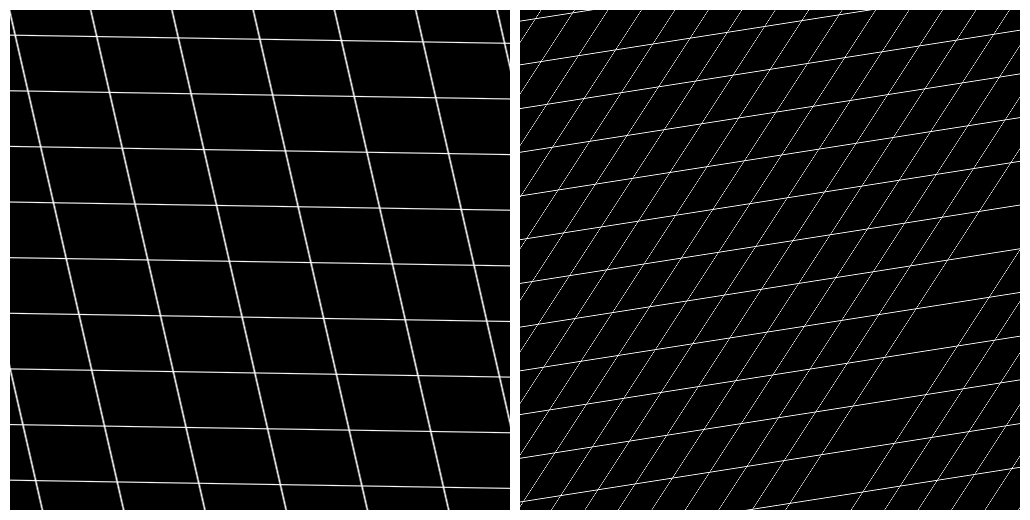

In [58]:
ref_ratio = 1.
alpha  = 1000
rng = np.random.default_rng(10)

transf_img1 = getAffineTransform(
    np.array(img),
    ref_ratio=-ref_ratio,
    alpha=alpha,
    rng=rng)


rng = np.random.default_rng(10)
transf_img2 = getAffineTransform(
    np.array(img),
    ref_ratio=ref_ratio,
    alpha=alpha,
    rng=rng)

ToPILImage()(make_grid([
    ToTensor()(ToPILImage()(transf_img1)),
    ToTensor()(ToPILImage()(transf_img2))],
    pad_value=1., 
    padding=10))

In [21]:
np.unique(transf_img1)

array([  0,   8,  16,  23,  24,  31,  32,  38,  39,  40,  46,  48,  53,
        54,  56,  60,  62,  64,  67,  72,  73,  74,  76,  77,  80,  85,
        88,  93,  96, 100, 101, 102, 103, 104, 106, 108, 109, 112, 113,
       114, 116, 118, 119, 120, 123, 124, 125, 127, 128, 129, 130, 132,
       134, 135, 136, 138, 139, 141, 143, 145, 147, 150, 151, 153, 155,
       157, 158, 159, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171,
       173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       189, 190, 191, 192, 193, 195, 197, 198, 199, 200, 201, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255], dtype=uint8)